# Calculate the probability of Illinois drivers' age given race 

The python file should do the following:
- Calculate Pr(age|race). 
- Given race, draw the age distribution curve
- Draw the spline on the curve

We will do them one by one.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
path = "/content/drive/MyDrive/Colab Notebooks/"

In [15]:
sos_data = pd.read_csv(path + "processed_sos.csv")
census_age = pd.read_csv(path+"census_age.csv")
census_race = pd.read_csv(path+"census_race.csv")

In [16]:
census_data = census_age.merge(census_race, how = "left", on = "Block Group" )
census_data.head(5)

,Block Group,Total:_x,All: Under 5 years,All: 5 to 9 years,All: 10 to 14 years,All: 15 to 17 years,All: 18 and 19 years,All: 20 years,All: 21 years,All: 22 to 24 years,...,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some other race,Two or more races,Hispanic or Latino,BG_Block_Group_num_y,BG_Census Tract_y,BG_County_y,BG_State_y
0,"Block Group 1, Census Tract 3018.01, Cook Coun...",1933,396,82,312,59,45,0,0,75,...,0,0,0,0,14,1886,1,3018.01,Cook County,Illinois
1,"Block Group 2, Census Tract 3018.02, Cook Coun...",1238,26,193,155,90,59,24,21,36,...,0,0,0,0,0,1191,2,3018.02,Cook County,Illinois
2,"Block Group 2, Census Tract 3018.03, Cook Coun...",1606,147,131,92,15,0,23,0,102,...,0,0,0,0,0,1606,2,3018.03,Cook County,Illinois
3,"Block Group 2, Census Tract 3102, Cook County,...",1009,83,40,31,14,0,0,0,23,...,0,135,0,0,6,445,2,3102.00,Cook County,Illinois
4,"Block Group 1, Census Tract 3105, Cook County,...",1434,107,70,86,22,16,0,17,109,...,0,7,0,0,0,1148,1,3105.00,Cook County,Illinois


In [17]:
census_data.columns

Index(['Block Group', 'Total:_x', 'All: Under 5 years', 'All: 5 to 9 years',
       'All: 10 to 14 years', 'All: 15 to 17 years', 'All: 18 and 19 years',
       'All: 20 years', 'All: 21 years', 'All: 22 to 24 years',
       'All: 25 to 29 years', 'All: 30 to 34 years', 'All: 35 to 39 years',
       'All: 40 to 44 years', 'All: 45 to 49 years', 'All: 50 to 54 years',
       'All: 55 to 59 years', 'All: 60 and 61 years', 'All: 62 to 64 years',
       'All: 65 and 66 years', 'All: 67 to 69 years', 'All: 70 to 74 years',
       'All: 75 to 79 years', 'All: 80 to 84 years', 'All: 85 years and over',
       'BG_Block_Group_num_x', 'BG_Census Tract_x', 'BG_County_x',
       'BG_State_x', 'Total:_y', 'Not Hispanic or Latino', 'White',
       'Black or African American', 'American Indian and Alaska Native',
       'Asian', 'Native Hawaiian and Other Pacific Islander',
       'Some other race', 'Two or more races', 'Hispanic or Latino',
       'BG_Block_Group_num_y', 'BG_Census Tract_y', 'BG_Co

## Getting Age Distribution of Drivers Pr(age = x) From the Secretary of State (SOS) data 

In [18]:
sos_data.head(10)

,AGE,MALE,FEMALE,TOTAL,YEAR
0,15 & Younger,32970,34029,66999,2019
1,16,59171,60321,119492,2019
2,17,64897,65122,130019,2019
3,18,68861,66440,135301,2019
4,19,72495,69046,141541,2019
5,20,74848,70052,144900,2019
6,21,67926,65824,133750,2019
7,22,72222,69236,141458,2019
8,23,77481,74764,152245,2019
9,24,82995,80028,163023,2019


In [126]:
sos_21 = sos_data[sos_data.loc[:, "YEAR"] == 2021].iloc[1:,:]
sos_21 = sos_21.astype({"AGE": "int"})
sos_21 = sos_21[sos_21.AGE < 85]

In [127]:
sos_21.loc[:,"SHARE"] = sos_21.TOTAL/sos_21.TOTAL.sum()

Share is P(Driver, Age = x): the distribution of drivers' age



In [128]:
sos_21 = sos_21.reset_index()
sos_21 = sos_21.iloc[:,1:]
sos_21.head(5)

,AGE,MALE,FEMALE,TOTAL,YEAR,SHARE
0,16,55600,55958,111558,2021,0.012742
1,17,62332,61865,124197,2021,0.014186
2,18,65644,63481,129125,2021,0.014749
3,19,68759,65467,134226,2021,0.015331
4,20,72707,69039,141746,2021,0.016190


In [129]:
sos_21.sort_values(by = "SHARE", ascending=False) # look at max and min values

,AGE,MALE,FEMALE,TOTAL,YEAR,SHARE
9,25,83519,80764,164283,2021,0.018765
13,29,82944,80883,163827,2021,0.018712
17,33,82022,80589,162611,2021,0.018574
16,32,80240,80121,160361,2021,0.018317
25,41,79041,80032,159073,2021,0.018169
...,...,...,...,...,...,...
64,80,21684,23733,45417,2021,0.005188
65,81,18630,20176,38806,2021,0.004432
66,82,16746,18315,35061,2021,0.004005
67,83,14145,15471,29616,2021,0.003383


In [112]:
sos_21.dtypes

AGE         int64
MALE        int64
FEMALE      int64
TOTAL       int64
YEAR        int64
SHARE     float64
dtype: object

In [130]:
num_driver = sum(sos_21.iloc[:,-3])
num_driver

8754982

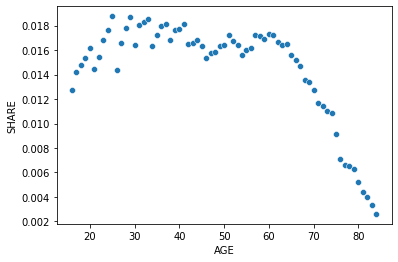

In [131]:
sns.scatterplot(data=sos_21, x = "AGE", y = "SHARE")

## Getting from Census data

In [64]:
census_data.columns

Index(['Block Group', 'Total:_x', 'All: Under 5 years', 'All: 5 to 9 years',
       'All: 10 to 14 years', 'All: 15 to 17 years', 'All: 18 and 19 years',
       'All: 20 years', 'All: 21 years', 'All: 22 to 24 years',
       'All: 25 to 29 years', 'All: 30 to 34 years', 'All: 35 to 39 years',
       'All: 40 to 44 years', 'All: 45 to 49 years', 'All: 50 to 54 years',
       'All: 55 to 59 years', 'All: 60 and 61 years', 'All: 62 to 64 years',
       'All: 65 and 66 years', 'All: 67 to 69 years', 'All: 70 to 74 years',
       'All: 75 to 79 years', 'All: 80 to 84 years', 'All: 85 years and over',
       'BG_Block_Group_num_x', 'BG_Census Tract_x', 'BG_County_x',
       'BG_State_x', 'Total:_y', 'Not Hispanic or Latino', 'White',
       'Black or African American', 'American Indian and Alaska Native',
       'Asian', 'Native Hawaiian and Other Pacific Islander',
       'Some other race', 'Two or more races', 'Hispanic or Latino',
       'BG_Block_Group_num_y', 'BG_Census Tract_y', 'BG_Co

In [80]:
census_data.shape

(4002, 43)

In [84]:
census_age = census_data[[col for col in census_data.columns if "All:" in col]]
#census_age.loc[:, "All"] = 
lst = []
for i in range(census_age.shape[0]):
  lst.append(sum(census_age.iloc[i,:]))
census_age.loc[:, "All"] = lst
census_age.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,All: Under 5 years,All: 5 to 9 years,All: 10 to 14 years,All: 15 to 17 years,All: 18 and 19 years,All: 20 years,All: 21 years,All: 22 to 24 years,All: 25 to 29 years,All: 30 to 34 years,...,All: 55 to 59 years,All: 60 and 61 years,All: 62 to 64 years,All: 65 and 66 years,All: 67 to 69 years,All: 70 to 74 years,All: 75 to 79 years,All: 80 to 84 years,All: 85 years and over,All
0,396,82,312,59,45,0,0,75,222,142,...,59,0,0,37,0,41,70,0,13,1933
1,26,193,155,90,59,24,21,36,92,43,...,34,1,7,9,19,31,30,1,0,1238
2,147,131,92,15,0,23,0,102,231,228,...,54,23,46,36,0,51,89,0,8,1606
3,83,40,31,14,0,0,0,23,157,196,...,57,39,25,51,8,7,0,0,16,1009
4,107,70,86,22,16,0,17,109,198,235,...,38,0,28,33,56,35,28,7,0,1434


In [85]:
total_pop = sum(census_age.iloc[:,-1])
total_pop

5169517

In [74]:
total_whites = sum(census_data.loc[:,"White"])
total_blacks = sum(census_data.loc[:,"Black or African American"])
total_asian = sum(census_data.loc[:, "Asian"])
total_americanindian = sum(census_data.loc[:, "American Indian and Alaska Native"])
total_pacific = sum(census_data.loc[:, "Native Hawaiian and Other Pacific Islander"])
total_hispanic = sum(census_data.loc[:, "Hispanic or Latino"])

In [132]:
age5 = sum(census_data.loc[:,"All: Under 5 years"])
age5_9 =  sum(census_data.loc[:,"All: 5 to 9 years"])
age10_14 =  sum(census_data.loc[:,"All: 10 to 14 years"])
age15_17 =  sum(census_data.loc[:,"All: 15 to 17 years"])
age18_19 =  sum(census_data.loc[:,"All: 18 and 19 years"])
age20  =  sum(census_data.loc[:,"All: 20 years"])
age21 =  sum(census_data.loc[:,"All: 21 years"])
age22_24 =  sum(census_data.loc[:,"All: 22 to 24 years"])
age25_29 =   sum(census_data.loc[:,"All: 25 to 29 years"])
age30_34=  sum(census_data.loc[:,"All: 30 to 34 years"])
age35_39 = sum(census_data.loc[:,"All: 35 to 39 years"])
age40_44 = sum(census_data.loc[:,"All: 40 to 44 years"])
age45_49 = sum(census_data.loc[:,"All: 45 to 49 years"])
age50_54 = sum(census_data.loc[:,"All: 50 to 54 years"])
age55_59 = sum(census_data.loc[:,"All: 55 to 59 years"])
age60_61 = sum(census_data.loc[:,"All: 60 and 61 years"])
age62_64 = sum(census_data.loc[:,"All: 62 to 64 years"])
age65_66 =  sum(census_data.loc[:,"All: 65 and 66 years"])
age67_69 = sum(census_data.loc[:,"All: 67 to 69 years"])
age70_74 = sum(census_data.loc[:,"All: 70 to 74 years"])
age75_79 = sum(census_data.loc[:,"All: 75 to 79 years"])
age80_84 = sum(census_data.loc[:,"All: 80 to 84 years"])
age85 = sum(census_data.loc[:,"All: 85 years and over"])

In [170]:
pop_age_lst = [
age15_17,
age18_19,
age20, 
age21, 
age22_24, 
age25_29, 
age30_34,
age35_39,
age40_44,
age45_49,
age50_54,
age55_59,
age60_61,
age62_64,
age65_66,
age67_69, 
age70_74,
age75_79,
age80_84] 
age_lst

[188610,
 121506,
 60065,
 63106,
 211282,
 432731,
 412096,
 366204,
 333521,
 326309,
 321429,
 330348,
 130989,
 173618,
 109098,
 138833,
 185932,
 129391,
 90243]

In [157]:
driver15_17 = sos_21.query('AGE >= 15 and AGE <=17').TOTAL.sum()
driver18_19 = sos_21.query('AGE >= 18 and AGE <=19').TOTAL.sum()
driver20 = sos_21.query('AGE == 20').TOTAL
driver21 = sos_21.query('AGE == 21').TOTAL
driver22_24 = sos_21.query('AGE >= 22 and AGE <= 24').TOTAL.sum()
driver25_29 = sos_21.query('AGE >= 25 and AGE <=29').TOTAL.sum()
driver30_34 = sos_21.query('AGE >= 30 and AGE <=34').TOTAL.sum()
driver35_39 = sos_21.query('AGE >= 35 and AGE <=39').TOTAL.sum()
driver40_44 = sos_21.query('AGE >= 40 and AGE <=44').TOTAL.sum()
driver45_49 = sos_21.query('AGE >= 45 and AGE <=49').TOTAL.sum()
driver50_54 = sos_21.query('AGE >= 50 and AGE <=54').TOTAL.sum()
driver55_59 = sos_21.query('AGE >= 55 and AGE <=59').TOTAL.sum()
driver60_61 = sos_21.query('AGE >= 60 and AGE <=61').TOTAL.sum()
driver62_64 = sos_21.query('AGE >= 62 and AGE <=64').TOTAL.sum()
driver65_66 = sos_21.query('AGE >= 65 and AGE <=66').TOTAL.sum()
driver67_69 = sos_21.query('AGE >= 67 and AGE <=69').TOTAL.sum()
driver70_74 = sos_21.query('AGE >= 70 and AGE <=74').TOTAL.sum()
driver75_79 = sos_21.query('AGE >= 75 and AGE <=79').TOTAL.sum()
driver80_84 = sos_21.query('AGE >= 80 and AGE <=84').TOTAL.sum()

In [160]:
driver_age_lst = [driver15_17,
driver18_19,
driver20,
driver21,
driver22_24,
driver25_29,
driver30_34,
driver35_39,
driver40_44,
driver45_49,
driver50_54,
driver55_59,
driver60_61,
driver62_64,
driver65_66,
driver67_69,
driver70_74,
driver75_79,
driver80_84]

In [171]:
age_lst = [(15,17), (18,19), 20, 21, (22,24), (25,29), (30,34), (35,39), (40,44), (45,49), (50,54), (55,59), (60,61), (63,64),
 (65,66), (67,69), (70,74), (75,59), (80,84)]

prob_lst = []
for i in range(len(driver_age_lst)):
  p = driver_age_lst[i]/pop_age_lst[i]
  #p = round(p, 4)
  prob_lst.append(p)
prob_lst


[1.2499602354063941, 2.1673909107369185, 4    2.359877
 Name: TOTAL, dtype: float64, 5    2.005388
 Name: TOTAL, dtype: float64, 2.067521132893479, 1.7461402118175033, 1.8618501514210282, 2.0975740297757532, 2.253576236578806, 2.13672316730461, 2.242647676469765, 2.209730344969547, 2.309560344761774, 2.4989862802244005, 2.4676896001759885, 2.6320111212752013, 2.7193006045220836, 2.408459630113377, 1.903693361257937]

In [172]:
prob_lst[0]

1.2499602354063941